## Plot Wflow static maps

**hydroMT** provides a simple interface to model schematization from which we can make beautiful plots:

- Raster layers are saved to the model `staticmaps` attribute as a  `xarray.Dataset`
- Vector layers are saved to the model `staticgeoms` attribute as a `geopandas.GeoDataFrame`. Note that in case of Wflow these are not used by the model engine, but only for analysis and visualization purposes.

We use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to plot maps. This packages provides a simple interface to plot geographic data and add background satellite imagery.

### Load dependencies

In [1]:
import pandas as pd
import xarray as xr
import numpy as  np
from os.path import join, dirname
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

In [2]:
import hydromt

### Read the model

In [3]:
root = 'wflow_piave_subbasin' 
mod = hydromt.WflowModel(root, mode='r')

### Plot model schematization base maps

Here we plot the model basemaps (topography map with rivers, lakes, reservoirs, glaciers and gauges geometries). 

In [4]:
# plot maps dependencies
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import descartes # required to plot polygons
import cartopy.io.img_tiles as cimgt

In [5]:
# read and mask the model elevation
da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
da.attrs.update(long_name='elevation', units='m')
# read/derive river geometries
gdf_riv = mod.rivers
# read/derive model basin boundary
gdf_bas = mod.basins

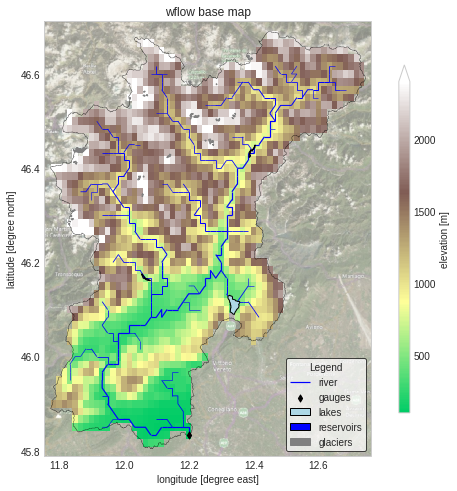

In [6]:
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)
shaded= False # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!


# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(
        dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords
    )
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)
                
# plot rivers with increasing width with stream order
kwargs = dict()
for strord in np.unique(gdf_riv['strord']):
    if strord == np.unique(gdf_riv['strord']).max():
        kwargs.update(label='river')
    gdf_riv[gdf_riv['strord']==strord].plot(ax=ax, linewidth=strord/5, color='blue', zorder=3, **kwargs)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
# plot various vector layers if present
if 'gauges' in mod.staticgeoms:
    mod.staticgeoms['gauges'].plot(ax=ax, marker='d', markersize=25, facecolor='k', zorder=5, label='gauges')
patches = [] # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if 'lakes' in mod.staticgeoms:
    kwargs = dict(facecolor='lightblue', edgecolor='black', linewidth=1, label='lakes')
    mod.staticgeoms['lakes'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if 'reservoirs' in mod.staticgeoms:
    kwargs = dict(facecolor='blue', edgecolor='black', linewidth=1, label='reservoirs')
    mod.staticgeoms['reservoirs'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if 'glaciers' in mod.staticgeoms:
    kwargs = dict(facecolor='grey', edgecolor='grey', linewidth=1, label='glaciers')
    mod.staticgeoms['glaciers'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
    
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc='lower right',
    frameon=True,
    framealpha=0.7,
    edgecolor='k',
    facecolor='white'
)

# save figure
# NOTE create figs folder in model root if it does not exist
# fn_out = join(mod.root, "figs", "basemap.png")
# plt.savefig(fn_out, dpi=225, bbox_inches="tight")